Calculation of rewards for the main branch. Currently all our mechs have the same main branch

In [ ]:
"""Script for optimization of a single topology"""
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.algorithms.moo.nsga2 import NSGA2
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints, CalculateMultiCriteriaProblem, MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import add_auxilary_points_to_trajectory, convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory, get_horizontal_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward, PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward, ZRRReward, MinForceReward, MinManipulabilityReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward

from auto_robot_design.generator.user_generator.graph_generator import TopologyManager2D
from auto_robot_design.description.kinematics import JointPoint
from auto_robot_design.description.builder import jps_graph2pinocchio_robot, jps_graph2pinocchio_robot_3d_constraints

#### Setup trajectories 

If the trajectory has an unreachable point the cell with reward calculation will fail!

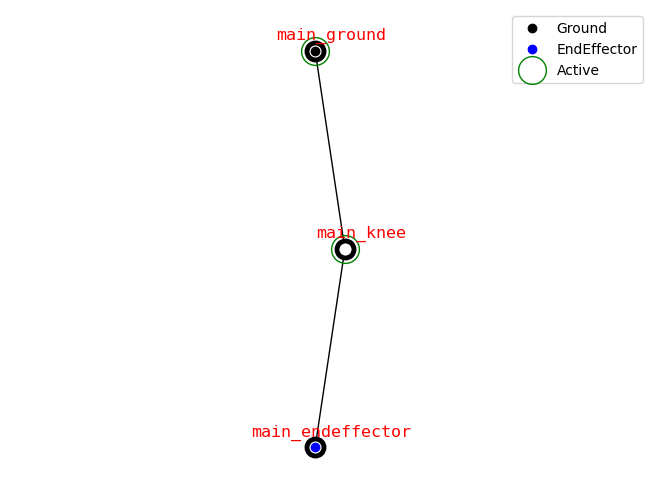

In [26]:
tp = TopologyManager2D()
# creates ground connection
main_ground_jp = JointPoint(r=None, w=np.array([0, 1, 0]), active=True, name='main_ground',attach_ground=True, attach_endeffector=False)
tp.add_absolute_node(jp=main_ground_jp, initial_coordinates=np.array([0, 0, 0]), mutation_range=[None,None,None], freeze_pos=np.array([0,0,0]))
main_knee_jp = JointPoint(r = None, w=np.array([0, 1, 0]), active=True, name='main_knee', attach_ground=False, attach_endeffector=False)
tp.add_absolute_node(jp=main_knee_jp, parent_branch_idx=0, initial_coordinates=[0.03, 0, -0.2], mutation_range=[None,None,(-0.1,0.1)], freeze_pos=np.array([0.03,0,None]))
# creates connection on the first link
tp.add_connection(ground=False, self_mutation_range= [(-0.2,0.2),None,(-0.4,0.4)], dependent_mutation_range=[(-0.1,0.1),None,(-0.1,0.1)])
main_endeffector_jp = JointPoint(r = None, w=np.array([0, 1, 0]), active=False, name='main_endeffector',attach_ground=False, attach_endeffector=True)
tp.add_absolute_node(jp=main_endeffector_jp, parent_branch_idx=0, initial_coordinates=np.array([0.0, 0, -0.4]), mutation_range=[None,None,None], freeze_pos=np.array([0.,0,-0.4]))

tp.set_mutation_ranges()
graph = tp.get_graph(tp.generate_central_from_mutation_range())
draw_joint_point(graph)

#### Characteristics to be calculated

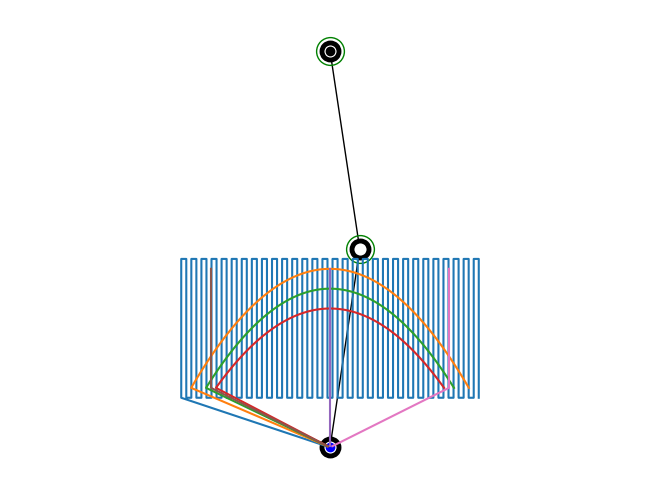

In [27]:
from auto_robot_design.utils.configs import get_standard_builder, get_standard_crag, get_standard_trajectories
builder = get_standard_builder()
crag = get_standard_crag(open_loop=True)
trajectories = get_standard_trajectories()


draw_joint_point(graph, draw_labels=False)
for _, trajectory in trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

#plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()

#### set the rewards and weights

In [28]:
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", reachability_key="is_reach", actuated_mass_key="Actuated_Mass")
heavy_lifting = MeanHeavyLiftingReward(manipulability_key='Manip_Jacobian', reachability_key="is_reach", mass_key="MASS")
actuator_list = [TMotor_AK10_9(), TMotor_AK60_6(), TMotor_AK70_10(), TMotor_AK80_64(), TMotor_AK80_9()]

In [29]:
trajectory = trajectories['step3']
error_calculator = PositioningErrorCalculator(jacobian_key="Manip_Jacobian")
soft_constraint = PositioningConstrain(error_calculator=error_calculator, points=[trajectory])

In [ ]:

fixed_robot, free_robot = jps_graph2pinocchio_robot_3d_constraints(graph, builder)
constrain_error, results = soft_constraint.calculate_constrain_error(crag, fixed_robot, free_robot)
results = results[0]

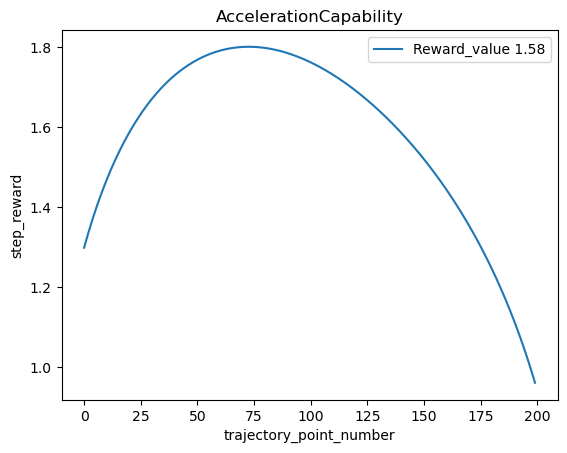

In [ ]:
reward, reward_list = acceleration_capability.calculate(results[0], results[1], results[2], Actuator = actuator_list[0])
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('AccelerationCapability')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()

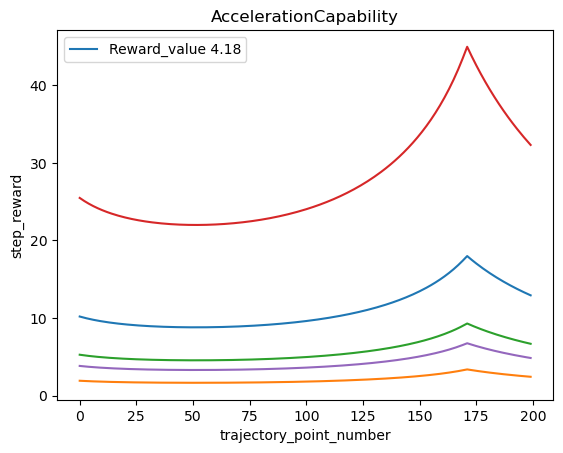

In [33]:
for i in range(5):
    reward, reward_list = heavy_lifting.calculate(results[0], results[1], results[2], Actuator = actuator_list[i])
    reward_vector = np.array(reward_list)
    plt.plot(reward_vector)

plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('AccelerationCapability')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()

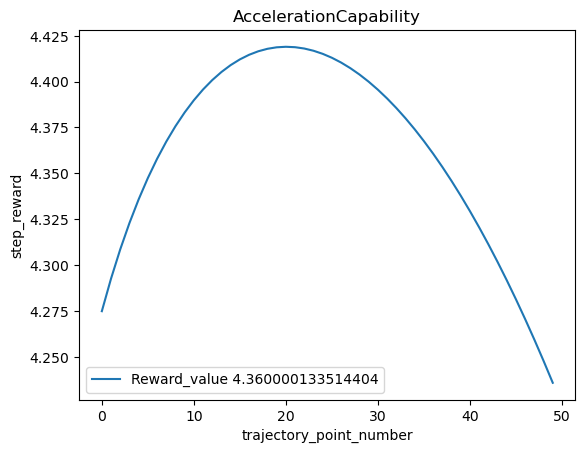

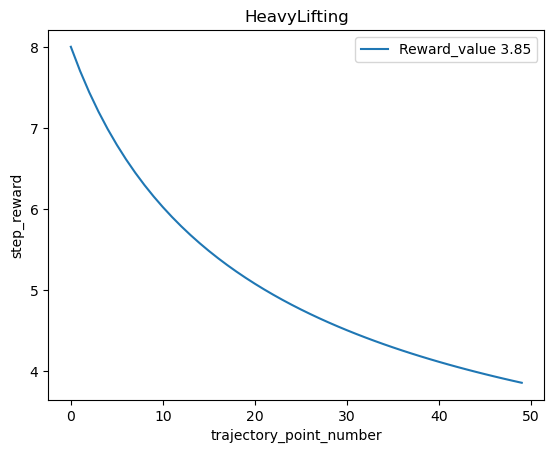

In [ ]:
point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = heavy_lifting.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator_list[0])
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('HeavyLifting')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()